# Import thu vien

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchmetrics
!pip install segmentation_models_pytorch

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
import albumentations as A
import torch.nn.functional as F
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import os
from glob import glob
from tqdm import tqdm
from PIL import Image
import timm
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Test

[0 1 2 3 4]


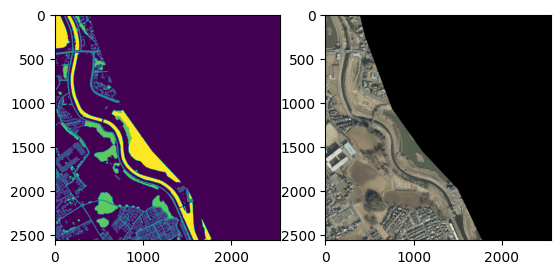

In [ ]:
mask_path = "/content/drive/MyDrive/NAVER/Mask2_resample/Mask_Row(249)_Col(322)_resample.tif"
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
img_path = "/content/drive/MyDrive/NAVER/TrueOrtho_resample/Ortho_Row(249)_Col(322)_resample.tif"
img= cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(mask)
plt.subplot(122)
plt.imshow(img)
print(np.unique(mask))

# Tao CustomDataset

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, root_dir, txt_file, transform = None):
    super().__init__()
    self.root_dir = root_dir
    self.txt_file= txt_file
    self.transform = transform
    self.img_path_list = []
    with open(self.txt_file) as file_in:
      for line in file_in:
        self.img_path_list.append(line)

  def __len__(self):
    return len(self.img_path_list)

  def __getitem__(self, idx):
    filename = self.img_path_list[idx]
    base, ext = os.path.splitext(filename)
    resample_filename1 = f"{base}{ext}"
    base2 = base.replace('Ortho', 'Mask_Building')
    resample_filename2 = f"{base2}{ext}"

    image_path = os.path.join(self.root_dir,"TrueOrtho_resample", resample_filename1.strip())
    mask_path = os.path.join(self.root_dir,"Mask2_Building_resample", resample_filename2.strip())
    image= cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if self.transform is not None:
      transformed = self.transform(image = image, mask = mask)
      transformed_image = transformed['image']
      transformed_mask = transformed['mask']
    return transformed_image, transformed_mask

# Augmentation anh

In [ ]:
train_transformed = A.Compose([
    A.Resize(width=512, height=512),
    A.HorizontalFlip(p=0.5), # Added probability for flip
    A.VerticalFlip(p=0.5), # Added vertical flip
    A.RandomRotate90(), # Added random rotation
    A.Transpose(p=0.5), # Added transpose
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, border_mode=cv2.BORDER_REFLECT), # Added shift, scale, rotate
    A.RandomBrightnessContrast(p=0.2), # Added probability for brightness contrast
    A.Blur(blur_limit=3), # Specified blur limit
    A.OpticalDistortion(), # Added optical distortion
    A.GridDistortion(), # Added grid distortion
    A.HueSaturationValue(), # Added hue saturation
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])


test_transformed = A.Compose([
    A.Resize(width=2048, height=2048),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

val_transformed = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])


In [ ]:
train_dataset = CustomDataset("/content/drive/MyDrive/NAVER", "/content/drive/MyDrive/Tiên/train.txt", train_transformed)
test_dataset = CustomDataset("/content/drive/MyDrive/NAVER", "/content/drive/MyDrive/Tiên/test.txt", test_transformed)
val_dataset = CustomDataset("/content/drive/MyDrive/NAVER", "/content/drive/MyDrive/Tiên/val.txt", val_transformed)
train_dataset.__getitem__(90)


(tensor([[[ 0.3309, -0.0116, -0.2342,  ..., -1.0733, -1.0733,  0.8276],
          [ 0.0569, -0.2856, -0.4911,  ..., -1.0390, -1.0390,  0.3138],
          [-0.1999, -0.5424, -0.7822,  ..., -1.0048, -1.0048,  0.2967],
          ...,
          [ 0.7077, -0.2171, -0.5938,  ...,  0.7762,  0.7762, -0.8335],
          [ 0.7077, -0.2171, -0.5938,  ...,  0.7762,  0.7762, -0.8335],
          [-1.1932, -1.1247, -0.6965,  ..., -0.6623, -0.6623, -1.1932]],
 
         [[ 0.4853,  0.1352, -0.0924,  ..., -0.7927, -0.7927,  1.1681],
          [ 0.2052, -0.1275, -0.3200,  ..., -0.7402, -0.7402,  0.5028],
          [-0.0574, -0.3725, -0.5476,  ..., -0.7052, -0.7052,  0.4153],
          ...,
          [ 0.8179, -0.1450, -0.4601,  ...,  0.7654,  0.7654, -0.5301],
          [ 0.8179, -0.1450, -0.4601,  ...,  0.7654,  0.7654, -0.5301],
          [-0.8978, -0.8102, -0.3725,  ..., -0.4951, -0.4951, -0.9678]],
 
         [[ 0.4439,  0.1825, -0.0267,  ..., -0.4973, -0.4973,  1.1934],
          [ 0.2348, -0.0267,

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))


# U Net model

In [ ]:
#model UNet
def unet_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1),
        nn.ReLU()
    )

class ResUnet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.backbone = timm.create_model("resnet50", pretrained=True, features_only=True)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
        self.block_neck = unet_block(2048, 1024)
        self.block_up1 = unet_block(1024+1024, 512)
        self.block_up2 = unet_block(512+512, 256)
        self.block_up3 = unet_block(256+256, 128)
        self.block_up4 = unet_block(128+64, 64)
        self.conv_cls = nn.Conv2d(64, self.n_classes, 1)

    def forward(self, x):
        x1, x2, x3, x4, x5 = self.backbone(x)
        x = self.block_neck(x5) # x (B, 1024, 8, 8)
        x = torch.cat([x4, self.upsample(x)], dim=1)
        x = self.block_up1(x)
        x = torch.cat([x3, self.upsample(x)], dim=1)
        x = self.block_up2(x)
        x = torch.cat([x2, self.upsample(x)], dim=1)
        x = self.block_up3(x)
        x = torch.cat([x1, self.upsample(x)], dim=1)
        x = self.block_up4(x)
        x = self.conv_cls(x) #size/2
        x = self.upsample(x)
        return x


In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Tinh Accuracy

In [ ]:
def accuracy_function(preds, targets):
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    acc_class = []
    for i in range(2):  # Assuming 2 classes
        indices = targets_flat == i
        total = indices.sum().item()
        if total > 0:
            correct = (preds_flat[indices] == targets_flat[indices]).sum().item()
            acc_class.append(correct / total)
    return sum(acc_class) / len(acc_class) if acc_class else 0

def recall(preds, targets):
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    indices = targets_flat == 1
    total = indices.sum().item()
    if total > 0:
        correct = (preds_flat[indices] == targets_flat[indices]).sum().item()
        return correct / total
    return 0

In [ ]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load data
batch_size = 10
n_workers = os.cpu_count()
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)
#model
model = ResUnet(2).to(device)

#loss
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_eps = 300

#metrics
dice_fn = torchmetrics.Dice(num_classes=2, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=2, task="binary", average="macro").to(device)

#meter
acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
dice_meter = AverageMeter()
iou_meter = AverageMeter()
recall_meter = AverageMeter()

num_workers = 2


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Train

In [ ]:
from torch.cuda.amp import GradScaler, autocast

# Initialize the gradient scaler
scaler = GradScaler()

# Set the number of accumulation steps
accumulation_steps = 10 # Adjust this value according to your memory limit

best_val_loss = float('inf')
accs = []
train_losses =[]
val_losses = []
dices = []
ious = []
best_epoch_preds, best_epoch_targets = None, None

for ep in range(1, 1+n_eps):
    acc_meter.reset()
    train_loss_meter.reset()
    dice_meter.reset()
    iou_meter.reset()
    recall_meter.reset()
    model.train()

    optimizer.zero_grad()  # Reset gradients tensors

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        n = x.shape[0]
        x = x.to(device)
        y = y.to(device).long()
        y_hat = model(x)
        y_hat = y_hat.squeeze()
        loss = criterion(y_hat, y)
        loss = loss / accumulation_steps  # Normalize our loss (if averaged)

        # Scales loss. Calls backward() on scaled loss to create scaled gradients.
        scaler.scale(loss).backward()

        # Backward passes without optimization every few batches
        if (batch_id + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        with torch.no_grad():
            y_hat_mask = y_hat.argmax(dim=1)
            dice_score = dice_fn(y_hat_mask, y)
            accuracy = accuracy_function(y_hat_mask, y)
            dice_score = dice_fn(y_hat_mask, y)
            iou_score = iou_fn(y_hat_mask,y)
            recall_score = recall(y_hat_mask, y)

            train_loss_meter.update(loss.item() * accumulation_steps, n)  # We have to scale our loss back
            dice_meter.update(dice_score, n)
            iou_meter.update(iou_score,n)
            acc_meter.update(accuracy, n)
            recall_meter.update(recall_score, n)

    accs.append(acc_meter.avg)
    train_losses.append(train_loss_meter.avg)
    model.eval()
    val_loss_meter = AverageMeter()
    with torch.no_grad():
        for x, y in valloader:
            x = x.to(device)
            y = y.to(device).long()
            y_hat = model(x)
            y_hat = y_hat.squeeze()
            loss = criterion(y_hat, y)
            val_loss_meter.update(loss, x.size(0))

    val_loss = val_loss_meter.avg
    dices.append(dice_meter.avg.cpu().item())
    val_losses.append(val_loss_meter.avg.cpu().item())
    ious.append(iou_meter.avg.cpu().item())
    print("EP {}, val loss = {:.6}".format(ep, val_loss))
    print("EP {}, train loss = {:.6f}, accuracy = {:.6f}, iou = {:.6f}, dice = {:.6f}, recall= {:.6f}".format(
       ep, train_loss_meter.avg, acc_meter.avg, iou_meter.avg, dice_meter.avg, recall_meter.avg
    ))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/content/best_model.pth")
        best_epoch_preds = y_hat.argmax(dim=1).view(-1).cpu().numpy()
        best_epoch_targets = y.view(-1).cpu().numpy()

100%|██████████| 10/10 [00:46<00:00,  4.61s/it]


EP 1, val loss = 0.970182
EP 1, train loss = 1.127322, accuracy = 0.499925, iou = 0.127137, dice = 0.111784, recall= 0.999838


100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


EP 2, val loss = 0.762095
EP 2, train loss = 0.925742, accuracy = 0.499614, iou = 0.128299, dice = 0.114013, recall= 0.998379


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


EP 3, val loss = 0.570604
EP 3, train loss = 0.750425, accuracy = 0.498011, iou = 0.118164, dice = 0.155722, recall= 0.889669


100%|██████████| 10/10 [00:29<00:00,  2.97s/it]


EP 4, val loss = 0.411838
EP 4, train loss = 0.589869, accuracy = 0.501300, iou = 0.007275, dice = 0.471483, recall= 0.007567


100%|██████████| 10/10 [00:27<00:00,  2.70s/it]


EP 5, val loss = 0.295666
EP 5, train loss = 0.460770, accuracy = 0.500347, iou = 0.001287, dice = 0.466651, recall= 0.001293


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


EP 6, val loss = 0.264147
EP 6, train loss = 0.404727, accuracy = 0.500002, iou = 0.000012, dice = 0.466002, recall= 0.000012


100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


EP 7, val loss = 0.253625
EP 7, train loss = 0.438155, accuracy = 0.500000, iou = 0.000001, dice = 0.465504, recall= 0.000001


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


EP 8, val loss = 0.249473
EP 8, train loss = 0.416544, accuracy = 0.500000, iou = 0.000000, dice = 0.465471, recall= 0.000000


100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


EP 9, val loss = 0.248917
EP 9, train loss = 0.386283, accuracy = 0.500000, iou = 0.000000, dice = 0.465922, recall= 0.000000


100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


EP 10, val loss = 0.250196
EP 10, train loss = 0.375225, accuracy = 0.500000, iou = 0.000000, dice = 0.465520, recall= 0.000000


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


EP 11, val loss = 0.250452
EP 11, train loss = 0.366552, accuracy = 0.500000, iou = 0.000000, dice = 0.466066, recall= 0.000000


100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


EP 12, val loss = 0.249643
EP 12, train loss = 0.366724, accuracy = 0.500000, iou = 0.000000, dice = 0.465305, recall= 0.000000


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


EP 13, val loss = 0.248488
EP 13, train loss = 0.363218, accuracy = 0.500000, iou = 0.000000, dice = 0.465524, recall= 0.000000


100%|██████████| 10/10 [00:26<00:00,  2.61s/it]


EP 14, val loss = 0.245211
EP 14, train loss = 0.359740, accuracy = 0.500000, iou = 0.000000, dice = 0.466023, recall= 0.000000


100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


EP 15, val loss = 0.24063
EP 15, train loss = 0.357803, accuracy = 0.500000, iou = 0.000000, dice = 0.465930, recall= 0.000000


100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


EP 16, val loss = 0.236193
EP 16, train loss = 0.354157, accuracy = 0.500000, iou = 0.000000, dice = 0.465784, recall= 0.000000


100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


EP 17, val loss = 0.229578
EP 17, train loss = 0.353016, accuracy = 0.500000, iou = 0.000000, dice = 0.465613, recall= 0.000000


100%|██████████| 10/10 [00:27<00:00,  2.73s/it]


EP 18, val loss = 0.223711
EP 18, train loss = 0.347559, accuracy = 0.500000, iou = 0.000000, dice = 0.465813, recall= 0.000000


100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


EP 19, val loss = 0.217759
EP 19, train loss = 0.346948, accuracy = 0.500000, iou = 0.000000, dice = 0.465581, recall= 0.000000


100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


EP 20, val loss = 0.212006
EP 20, train loss = 0.344497, accuracy = 0.500000, iou = 0.000000, dice = 0.465444, recall= 0.000000


100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


EP 21, val loss = 0.208134
EP 21, train loss = 0.339622, accuracy = 0.500000, iou = 0.000000, dice = 0.465775, recall= 0.000000


100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


EP 22, val loss = 0.202166
EP 22, train loss = 0.337632, accuracy = 0.500000, iou = 0.000000, dice = 0.465529, recall= 0.000000


100%|██████████| 10/10 [00:25<00:00,  2.55s/it]


EP 23, val loss = 0.198452
EP 23, train loss = 0.330706, accuracy = 0.500000, iou = 0.000000, dice = 0.466274, recall= 0.000000


100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


EP 24, val loss = 0.195725
EP 24, train loss = 0.331851, accuracy = 0.500000, iou = 0.000000, dice = 0.465267, recall= 0.000000


100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


EP 25, val loss = 0.193192
EP 25, train loss = 0.330514, accuracy = 0.500000, iou = 0.000000, dice = 0.465351, recall= 0.000000


100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


EP 26, val loss = 0.188581
EP 26, train loss = 0.331421, accuracy = 0.500007, iou = 0.000016, dice = 0.464878, recall= 0.000016


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


EP 27, val loss = 0.184608
EP 27, train loss = 0.327727, accuracy = 0.500005, iou = 0.000014, dice = 0.465429, recall= 0.000014


100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


EP 28, val loss = 0.181813
EP 28, train loss = 0.323409, accuracy = 0.500005, iou = 0.000013, dice = 0.465258, recall= 0.000013


100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


EP 29, val loss = 0.178945
EP 29, train loss = 0.320382, accuracy = 0.500080, iou = 0.000165, dice = 0.465734, recall= 0.000165


100%|██████████| 10/10 [00:27<00:00,  2.73s/it]


EP 30, val loss = 0.174277
EP 30, train loss = 0.314254, accuracy = 0.500024, iou = 0.000057, dice = 0.465827, recall= 0.000057


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


EP 31, val loss = 0.169242
EP 31, train loss = 0.316761, accuracy = 0.500101, iou = 0.000208, dice = 0.465733, recall= 0.000208


100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


EP 32, val loss = 0.165626
EP 32, train loss = 0.306975, accuracy = 0.500024, iou = 0.000053, dice = 0.465568, recall= 0.000053


100%|██████████| 10/10 [00:27<00:00,  2.70s/it]


EP 33, val loss = 0.160168
EP 33, train loss = 0.306335, accuracy = 0.500077, iou = 0.000160, dice = 0.465729, recall= 0.000160


100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


EP 34, val loss = 0.155677
EP 34, train loss = 0.302599, accuracy = 0.503257, iou = 0.006676, dice = 0.472054, recall= 0.007029


100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


EP 35, val loss = 0.152382
EP 35, train loss = 0.307009, accuracy = 0.505461, iou = 0.010826, dice = 0.475688, recall= 0.011541


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


EP 36, val loss = 0.147396
EP 36, train loss = 0.291423, accuracy = 0.505909, iou = 0.011959, dice = 0.477355, recall= 0.011999


100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


EP 37, val loss = 0.142733
EP 37, train loss = 0.290037, accuracy = 0.517028, iou = 0.033550, dice = 0.497039, recall= 0.035355


100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


EP 38, val loss = 0.142312
EP 38, train loss = 0.299321, accuracy = 0.509627, iou = 0.019487, dice = 0.484515, recall= 0.019724


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


EP 39, val loss = 0.136693
EP 39, train loss = 0.278264, accuracy = 0.507328, iou = 0.014877, dice = 0.480071, recall= 0.014987


100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


EP 40, val loss = 0.13601
EP 40, train loss = 0.281236, accuracy = 0.532495, iou = 0.063607, dice = 0.522830, recall= 0.067511


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


EP 41, val loss = 0.134201
EP 41, train loss = 0.284039, accuracy = 0.578042, iou = 0.135269, dice = 0.578723, recall= 0.168903


100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


EP 42, val loss = 0.130663
EP 42, train loss = 0.274263, accuracy = 0.588580, iou = 0.129909, dice = 0.577082, recall= 0.191891


100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


EP 43, val loss = 0.130595
EP 43, train loss = 0.278431, accuracy = 0.554887, iou = 0.105159, dice = 0.557901, recall= 0.117203


100%|██████████| 10/10 [00:25<00:00,  2.54s/it]


EP 44, val loss = 0.131086
EP 44, train loss = 0.261393, accuracy = 0.556308, iou = 0.111452, dice = 0.565680, recall= 0.120423


100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


EP 45, val loss = 0.130293
EP 45, train loss = 0.258402, accuracy = 0.576719, iou = 0.137255, dice = 0.582398, recall= 0.164099


100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


EP 46, val loss = 0.130599
EP 46, train loss = 0.273590, accuracy = 0.577417, iou = 0.119853, dice = 0.568381, recall= 0.167308


100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


EP 47, val loss = 0.128914
EP 47, train loss = 0.254729, accuracy = 0.581082, iou = 0.155212, dice = 0.599470, recall= 0.174637


100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


EP 48, val loss = 0.129017
EP 48, train loss = 0.258943, accuracy = 0.570304, iou = 0.134719, dice = 0.583087, recall= 0.154145


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


EP 49, val loss = 0.127871
EP 49, train loss = 0.254438, accuracy = 0.560385, iou = 0.119990, dice = 0.573395, recall= 0.126080


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


EP 50, val loss = 0.127402
EP 50, train loss = 0.273669, accuracy = 0.589484, iou = 0.140661, dice = 0.583374, recall= 0.191355


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


EP 51, val loss = 0.126247
EP 51, train loss = 0.251373, accuracy = 0.565466, iou = 0.111157, dice = 0.562405, recall= 0.135093


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


EP 52, val loss = 0.127357
EP 52, train loss = 0.253280, accuracy = 0.560932, iou = 0.109702, dice = 0.561837, recall= 0.127482


100%|██████████| 10/10 [00:30<00:00,  3.10s/it]


EP 53, val loss = 0.127577
EP 53, train loss = 0.250501, accuracy = 0.591330, iou = 0.167405, dice = 0.608391, recall= 0.194267


100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


EP 54, val loss = 0.124885
EP 54, train loss = 0.253568, accuracy = 0.600627, iou = 0.179521, dice = 0.616804, recall= 0.214729


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


EP 55, val loss = 0.124523
EP 55, train loss = 0.247536, accuracy = 0.578275, iou = 0.151141, dice = 0.597328, recall= 0.165465


100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


EP 56, val loss = 0.125067
EP 56, train loss = 0.246878, accuracy = 0.587577, iou = 0.153236, dice = 0.597658, recall= 0.185775


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


EP 57, val loss = 0.124679
EP 57, train loss = 0.244714, accuracy = 0.643307, iou = 0.257735, dice = 0.671769, recall= 0.312407


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


EP 58, val loss = 0.127214
EP 58, train loss = 0.244618, accuracy = 0.640931, iou = 0.243345, dice = 0.660787, recall= 0.312145


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


EP 59, val loss = 0.124032
EP 59, train loss = 0.245338, accuracy = 0.591008, iou = 0.175791, dice = 0.615864, recall= 0.192178


100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


EP 60, val loss = 0.123211
EP 60, train loss = 0.238233, accuracy = 0.626394, iou = 0.235047, dice = 0.657279, recall= 0.273141


100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


EP 61, val loss = 0.122765
EP 61, train loss = 0.238400, accuracy = 0.651110, iou = 0.267798, dice = 0.679196, recall= 0.329063


100%|██████████| 10/10 [00:26<00:00,  2.70s/it]


EP 62, val loss = 0.126014
EP 62, train loss = 0.238492, accuracy = 0.618220, iou = 0.218901, dice = 0.647501, recall= 0.252962


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


EP 63, val loss = 0.122394
EP 63, train loss = 0.240430, accuracy = 0.609418, iou = 0.207059, dice = 0.637776, recall= 0.235186


100%|██████████| 10/10 [00:23<00:00,  2.35s/it]


EP 64, val loss = 0.121298
EP 64, train loss = 0.237684, accuracy = 0.638820, iou = 0.245677, dice = 0.663365, recall= 0.298902


100%|██████████| 10/10 [00:23<00:00,  2.36s/it]


EP 65, val loss = 0.123715
EP 65, train loss = 0.235499, accuracy = 0.637516, iou = 0.257525, dice = 0.673557, recall= 0.298102


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


EP 66, val loss = 0.120722
EP 66, train loss = 0.240266, accuracy = 0.609425, iou = 0.206444, dice = 0.638223, recall= 0.232769


100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


EP 67, val loss = 0.120077
EP 67, train loss = 0.237774, accuracy = 0.663873, iou = 0.281821, dice = 0.687343, recall= 0.359878


100%|██████████| 10/10 [00:25<00:00,  2.60s/it]


EP 68, val loss = 0.125012
EP 68, train loss = 0.235505, accuracy = 0.659198, iou = 0.282108, dice = 0.686791, recall= 0.350454


100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


EP 69, val loss = 0.120502
EP 69, train loss = 0.231854, accuracy = 0.617823, iou = 0.221822, dice = 0.649460, recall= 0.249612


100%|██████████| 10/10 [00:26<00:00,  2.67s/it]


EP 70, val loss = 0.119737
EP 70, train loss = 0.233381, accuracy = 0.653649, iou = 0.273589, dice = 0.682648, recall= 0.334149


100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


EP 71, val loss = 0.125838
EP 71, train loss = 0.232311, accuracy = 0.695011, iou = 0.315899, dice = 0.706690, recall= 0.427326


100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


EP 72, val loss = 0.121839
EP 72, train loss = 0.234303, accuracy = 0.625535, iou = 0.235581, dice = 0.658416, recall= 0.268590


100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


EP 73, val loss = 0.118757
EP 73, train loss = 0.231764, accuracy = 0.656496, iou = 0.272320, dice = 0.682467, recall= 0.339013


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


EP 74, val loss = 0.126969
EP 74, train loss = 0.233239, accuracy = 0.704180, iou = 0.323935, dice = 0.711894, recall= 0.448829


100%|██████████| 10/10 [00:25<00:00,  2.54s/it]


EP 75, val loss = 0.125436
EP 75, train loss = 0.234401, accuracy = 0.629700, iou = 0.243898, dice = 0.663822, recall= 0.277204


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


EP 76, val loss = 0.118181
EP 76, train loss = 0.229565, accuracy = 0.635018, iou = 0.251524, dice = 0.669913, recall= 0.287826


100%|██████████| 10/10 [00:26<00:00,  2.67s/it]


EP 77, val loss = 0.11928
EP 77, train loss = 0.230000, accuracy = 0.684834, iou = 0.319177, dice = 0.710613, recall= 0.404831


100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


EP 78, val loss = 0.127762
EP 78, train loss = 0.232818, accuracy = 0.661945, iou = 0.274416, dice = 0.682992, recall= 0.348135


100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


EP 79, val loss = 0.125539
EP 79, train loss = 0.221275, accuracy = 0.623854, iou = 0.237304, dice = 0.661898, recall= 0.261981


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


EP 80, val loss = 0.117963
EP 80, train loss = 0.222836, accuracy = 0.647792, iou = 0.272238, dice = 0.683023, recall= 0.315523


100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


EP 81, val loss = 0.123847
EP 81, train loss = 0.225242, accuracy = 0.685391, iou = 0.323393, dice = 0.712786, recall= 0.405808


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


EP 82, val loss = 0.126922
EP 82, train loss = 0.221357, accuracy = 0.650451, iou = 0.280741, dice = 0.689577, recall= 0.320387


100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


EP 83, val loss = 0.11962
EP 83, train loss = 0.227531, accuracy = 0.639513, iou = 0.256592, dice = 0.672609, recall= 0.298759


100%|██████████| 10/10 [00:24<00:00,  2.50s/it]


EP 84, val loss = 0.119958
EP 84, train loss = 0.223314, accuracy = 0.701394, iou = 0.346062, dice = 0.726748, recall= 0.439161


100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


EP 85, val loss = 0.128421
EP 85, train loss = 0.223358, accuracy = 0.670360, iou = 0.307550, dice = 0.704409, recall= 0.367303


100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


EP 86, val loss = 0.125136
EP 86, train loss = 0.221838, accuracy = 0.663225, iou = 0.299015, dice = 0.699956, recall= 0.347918


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


EP 87, val loss = 0.125324
EP 87, train loss = 0.215595, accuracy = 0.667919, iou = 0.302844, dice = 0.702921, recall= 0.357042


100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


EP 88, val loss = 0.119156
EP 88, train loss = 0.219407, accuracy = 0.666699, iou = 0.304659, dice = 0.702455, recall= 0.356827


100%|██████████| 10/10 [00:23<00:00,  2.40s/it]


EP 89, val loss = 0.120382
EP 89, train loss = 0.220704, accuracy = 0.674301, iou = 0.312866, dice = 0.708120, recall= 0.377265


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


EP 90, val loss = 0.120108
EP 90, train loss = 0.215594, accuracy = 0.656627, iou = 0.293614, dice = 0.697602, recall= 0.332145


100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


EP 91, val loss = 0.114029
EP 91, train loss = 0.216601, accuracy = 0.679602, iou = 0.315500, dice = 0.710233, recall= 0.383768


100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


EP 92, val loss = 0.123782
EP 92, train loss = 0.224075, accuracy = 0.722324, iou = 0.362508, dice = 0.734932, recall= 0.488520


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


EP 93, val loss = 0.117563
EP 93, train loss = 0.219709, accuracy = 0.649776, iou = 0.276534, dice = 0.686067, recall= 0.317955


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


EP 94, val loss = 0.113458
EP 94, train loss = 0.221669, accuracy = 0.689599, iou = 0.327053, dice = 0.716007, recall= 0.411234


100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


EP 95, val loss = 0.134377
EP 95, train loss = 0.223299, accuracy = 0.738367, iou = 0.384358, dice = 0.745970, recall= 0.530695


100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


EP 96, val loss = 0.125276
EP 96, train loss = 0.218875, accuracy = 0.625837, iou = 0.243465, dice = 0.666532, recall= 0.262683


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


EP 97, val loss = 0.112764
EP 97, train loss = 0.219817, accuracy = 0.667292, iou = 0.289305, dice = 0.693400, recall= 0.353357


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


EP 98, val loss = 0.115572
EP 98, train loss = 0.220172, accuracy = 0.740860, iou = 0.389123, dice = 0.749763, recall= 0.529198


100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


EP 99, val loss = 0.123742
EP 99, train loss = 0.212637, accuracy = 0.685697, iou = 0.332962, dice = 0.720964, recall= 0.396593


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


EP 100, val loss = 0.113092
EP 100, train loss = 0.219250, accuracy = 0.635501, iou = 0.258663, dice = 0.675789, recall= 0.283991


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


EP 101, val loss = 0.112226
EP 101, train loss = 0.212087, accuracy = 0.690343, iou = 0.339086, dice = 0.724919, recall= 0.407764


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


EP 102, val loss = 0.116877
EP 102, train loss = 0.216719, accuracy = 0.731716, iou = 0.372855, dice = 0.742043, recall= 0.503461


100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


EP 103, val loss = 0.117934
EP 103, train loss = 0.212692, accuracy = 0.667562, iou = 0.310620, dice = 0.707806, recall= 0.353890


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


EP 104, val loss = 0.113921
EP 104, train loss = 0.211087, accuracy = 0.671289, iou = 0.316478, dice = 0.711379, recall= 0.364709


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


EP 105, val loss = 0.115484
EP 105, train loss = 0.211253, accuracy = 0.705128, iou = 0.356390, dice = 0.734309, recall= 0.442449


100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


EP 106, val loss = 0.123229
EP 106, train loss = 0.214469, accuracy = 0.709617, iou = 0.360150, dice = 0.735511, recall= 0.451911


100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


EP 107, val loss = 0.11725
EP 107, train loss = 0.215029, accuracy = 0.649063, iou = 0.281172, dice = 0.690788, recall= 0.314057


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


EP 108, val loss = 0.111619
EP 108, train loss = 0.214199, accuracy = 0.681279, iou = 0.329868, dice = 0.718680, recall= 0.388499


100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


EP 109, val loss = 0.111761
EP 109, train loss = 0.218923, accuracy = 0.734611, iou = 0.389408, dice = 0.749834, recall= 0.516070


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


EP 110, val loss = 0.121494
EP 110, train loss = 0.211429, accuracy = 0.689406, iou = 0.341311, dice = 0.725787, recall= 0.404477


100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


EP 111, val loss = 0.11598
EP 111, train loss = 0.212139, accuracy = 0.649038, iou = 0.284158, dice = 0.692321, recall= 0.311738


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


EP 112, val loss = 0.110716
EP 112, train loss = 0.213298, accuracy = 0.665414, iou = 0.307303, dice = 0.706513, recall= 0.348955


100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


EP 113, val loss = 0.110659
EP 113, train loss = 0.213159, accuracy = 0.735142, iou = 0.394699, dice = 0.754218, recall= 0.509123


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


EP 114, val loss = 0.120139
EP 114, train loss = 0.212481, accuracy = 0.717198, iou = 0.367883, dice = 0.739925, recall= 0.467193


100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


EP 115, val loss = 0.117798
EP 115, train loss = 0.212599, accuracy = 0.649898, iou = 0.283993, dice = 0.691724, recall= 0.311774


100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


EP 116, val loss = 0.110772
EP 116, train loss = 0.212389, accuracy = 0.659378, iou = 0.299754, dice = 0.702179, recall= 0.334018


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


EP 117, val loss = 0.110747
EP 117, train loss = 0.207481, accuracy = 0.738446, iou = 0.399954, dice = 0.757363, recall= 0.517503


100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


EP 118, val loss = 0.122496
EP 118, train loss = 0.217552, accuracy = 0.747171, iou = 0.399687, dice = 0.754418, recall= 0.537126


100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


EP 119, val loss = 0.12229
EP 119, train loss = 0.211850, accuracy = 0.663332, iou = 0.301695, dice = 0.703434, recall= 0.342675


100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


EP 120, val loss = 0.110182
EP 120, train loss = 0.211774, accuracy = 0.667574, iou = 0.312658, dice = 0.708309, recall= 0.352555


100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


EP 121, val loss = 0.110157
EP 121, train loss = 0.204003, accuracy = 0.733560, iou = 0.397786, dice = 0.756894, recall= 0.504940


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


EP 122, val loss = 0.112979
EP 122, train loss = 0.208748, accuracy = 0.733779, iou = 0.394980, dice = 0.755186, recall= 0.507022


100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


EP 123, val loss = 0.117885
EP 123, train loss = 0.207321, accuracy = 0.682529, iou = 0.333902, dice = 0.722368, recall= 0.386222


100%|██████████| 10/10 [00:26<00:00,  2.61s/it]


EP 124, val loss = 0.112531
EP 124, train loss = 0.209591, accuracy = 0.656654, iou = 0.297729, dice = 0.700731, recall= 0.327544


100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


EP 125, val loss = 0.110304
EP 125, train loss = 0.207561, accuracy = 0.691307, iou = 0.340851, dice = 0.725905, recall= 0.407670


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


EP 126, val loss = 0.111191
EP 126, train loss = 0.211978, accuracy = 0.713936, iou = 0.372092, dice = 0.742452, recall= 0.462145


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


EP 127, val loss = 0.11268
EP 127, train loss = 0.206647, accuracy = 0.713264, iou = 0.369843, dice = 0.741884, recall= 0.456479


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


EP 128, val loss = 0.113231
EP 128, train loss = 0.205017, accuracy = 0.691548, iou = 0.348504, dice = 0.730768, recall= 0.406864


100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


EP 129, val loss = 0.112121
EP 129, train loss = 0.208550, accuracy = 0.678814, iou = 0.330109, dice = 0.719692, recall= 0.378540


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


EP 130, val loss = 0.110744
EP 130, train loss = 0.204039, accuracy = 0.721039, iou = 0.383370, dice = 0.749873, recall= 0.473989


100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


EP 131, val loss = 0.110618
EP 131, train loss = 0.204730, accuracy = 0.713228, iou = 0.373196, dice = 0.744150, recall= 0.455234


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


EP 132, val loss = 0.110032
EP 132, train loss = 0.201549, accuracy = 0.713690, iou = 0.376810, dice = 0.746471, recall= 0.455985


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


EP 133, val loss = 0.114061
EP 133, train loss = 0.208501, accuracy = 0.699322, iou = 0.354667, dice = 0.733996, recall= 0.423887


100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


EP 134, val loss = 0.109111
EP 134, train loss = 0.205668, accuracy = 0.675861, iou = 0.326121, dice = 0.718017, recall= 0.371782


100%|██████████| 10/10 [00:26<00:00,  2.70s/it]


EP 135, val loss = 0.109017
EP 135, train loss = 0.203583, accuracy = 0.709553, iou = 0.371314, dice = 0.743488, recall= 0.447724


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]


EP 136, val loss = 0.10914
EP 136, train loss = 0.199041, accuracy = 0.738432, iou = 0.408286, dice = 0.762877, recall= 0.513168


100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


EP 137, val loss = 0.109772
EP 137, train loss = 0.206927, accuracy = 0.708592, iou = 0.371113, dice = 0.742030, recall= 0.444132


100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


EP 138, val loss = 0.109554
EP 138, train loss = 0.205812, accuracy = 0.703539, iou = 0.366550, dice = 0.738729, recall= 0.429830


100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


EP 139, val loss = 0.108876
EP 139, train loss = 0.200390, accuracy = 0.723100, iou = 0.384918, dice = 0.750480, recall= 0.474838


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


EP 140, val loss = 0.110023
EP 140, train loss = 0.206914, accuracy = 0.710607, iou = 0.369835, dice = 0.741763, recall= 0.448737


100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


EP 141, val loss = 0.112436
EP 141, train loss = 0.200290, accuracy = 0.715313, iou = 0.380712, dice = 0.748929, recall= 0.457128


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


EP 142, val loss = 0.110523
EP 142, train loss = 0.199369, accuracy = 0.703119, iou = 0.366634, dice = 0.741670, recall= 0.429185


100%|██████████| 10/10 [00:24<00:00,  2.48s/it]


EP 143, val loss = 0.109816
EP 143, train loss = 0.200680, accuracy = 0.710638, iou = 0.375819, dice = 0.746287, recall= 0.446553


100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


EP 144, val loss = 0.112338
EP 144, train loss = 0.201316, accuracy = 0.715819, iou = 0.381018, dice = 0.748662, recall= 0.460973


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


EP 145, val loss = 0.110693
EP 145, train loss = 0.202122, accuracy = 0.712611, iou = 0.377978, dice = 0.747372, recall= 0.454007


100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


EP 146, val loss = 0.109262
EP 146, train loss = 0.202185, accuracy = 0.725688, iou = 0.390369, dice = 0.753390, recall= 0.482793


100%|██████████| 10/10 [00:27<00:00,  2.78s/it]


EP 147, val loss = 0.110437
EP 147, train loss = 0.200931, accuracy = 0.711882, iou = 0.375816, dice = 0.745825, recall= 0.451029


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


EP 148, val loss = 0.108592
EP 148, train loss = 0.198736, accuracy = 0.697499, iou = 0.359536, dice = 0.737678, recall= 0.417560


100%|██████████| 10/10 [00:29<00:00,  2.90s/it]


EP 149, val loss = 0.107092
EP 149, train loss = 0.199092, accuracy = 0.713034, iou = 0.381252, dice = 0.749060, recall= 0.451492


100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


EP 150, val loss = 0.109171
EP 150, train loss = 0.204641, accuracy = 0.731150, iou = 0.398844, dice = 0.757649, recall= 0.496614


100%|██████████| 10/10 [00:27<00:00,  2.70s/it]


EP 151, val loss = 0.111213
EP 151, train loss = 0.199362, accuracy = 0.701317, iou = 0.363812, dice = 0.739878, recall= 0.424716


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


EP 152, val loss = 0.108065
EP 152, train loss = 0.198880, accuracy = 0.690003, iou = 0.346073, dice = 0.729888, recall= 0.399638


100%|██████████| 10/10 [00:25<00:00,  2.55s/it]


EP 153, val loss = 0.107864
EP 153, train loss = 0.195659, accuracy = 0.726161, iou = 0.399366, dice = 0.759058, recall= 0.479510


100%|██████████| 10/10 [00:25<00:00,  2.55s/it]


EP 154, val loss = 0.110906
EP 154, train loss = 0.201358, accuracy = 0.727156, iou = 0.395140, dice = 0.755914, recall= 0.488814


100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


EP 155, val loss = 0.113788
EP 155, train loss = 0.199980, accuracy = 0.722395, iou = 0.392132, dice = 0.754704, recall= 0.473484


100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


EP 156, val loss = 0.110571
EP 156, train loss = 0.198216, accuracy = 0.707432, iou = 0.375610, dice = 0.746328, recall= 0.439461


100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


EP 157, val loss = 0.109349
EP 157, train loss = 0.198785, accuracy = 0.716932, iou = 0.387356, dice = 0.752346, recall= 0.461879


100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


EP 158, val loss = 0.107733
EP 158, train loss = 0.195255, accuracy = 0.726717, iou = 0.400670, dice = 0.759414, recall= 0.480961


100%|██████████| 10/10 [00:27<00:00,  2.80s/it]


EP 159, val loss = 0.107977
EP 159, train loss = 0.197774, accuracy = 0.722482, iou = 0.390110, dice = 0.753905, recall= 0.471549


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


EP 160, val loss = 0.107439
EP 160, train loss = 0.199121, accuracy = 0.710650, iou = 0.375171, dice = 0.745479, recall= 0.446911


100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


EP 161, val loss = 0.11326
EP 161, train loss = 0.200004, accuracy = 0.745692, iou = 0.414987, dice = 0.765598, recall= 0.527920


100%|██████████| 10/10 [00:26<00:00,  2.61s/it]


EP 162, val loss = 0.109522
EP 162, train loss = 0.198622, accuracy = 0.705101, iou = 0.374033, dice = 0.744139, recall= 0.432632


100%|██████████| 10/10 [00:25<00:00,  2.54s/it]


EP 163, val loss = 0.106961
EP 163, train loss = 0.198897, accuracy = 0.714072, iou = 0.383110, dice = 0.750017, recall= 0.453979


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


EP 164, val loss = 0.109723
EP 164, train loss = 0.198624, accuracy = 0.756561, iou = 0.424547, dice = 0.771181, recall= 0.554230


100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


EP 165, val loss = 0.111164
EP 165, train loss = 0.197190, accuracy = 0.703711, iou = 0.368802, dice = 0.742294, recall= 0.429178


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


EP 166, val loss = 0.106462
EP 166, train loss = 0.198222, accuracy = 0.694608, iou = 0.360094, dice = 0.737483, recall= 0.410305


100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


EP 167, val loss = 0.106797
EP 167, train loss = 0.195750, accuracy = 0.744320, iou = 0.420264, dice = 0.769626, recall= 0.523637


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


EP 168, val loss = 0.114709
EP 168, train loss = 0.198564, accuracy = 0.740961, iou = 0.390518, dice = 0.753628, recall= 0.513618


100%|██████████| 10/10 [00:26<00:00,  2.67s/it]


EP 169, val loss = 0.108147
EP 169, train loss = 0.197324, accuracy = 0.684945, iou = 0.344122, dice = 0.730070, recall= 0.387072


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]


EP 170, val loss = 0.107263
EP 170, train loss = 0.193259, accuracy = 0.721949, iou = 0.395764, dice = 0.757176, recall= 0.469357


100%|██████████| 10/10 [00:27<00:00,  2.78s/it]


EP 171, val loss = 0.108958
EP 171, train loss = 0.196573, accuracy = 0.745461, iou = 0.419887, dice = 0.769290, recall= 0.527346


100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


EP 172, val loss = 0.108895
EP 172, train loss = 0.195755, accuracy = 0.707109, iou = 0.377252, dice = 0.747258, recall= 0.436659


100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


EP 173, val loss = 0.106663
EP 173, train loss = 0.193736, accuracy = 0.711452, iou = 0.382186, dice = 0.750265, recall= 0.445790


100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


EP 174, val loss = 0.107625
EP 174, train loss = 0.199542, accuracy = 0.736987, iou = 0.408974, dice = 0.762960, recall= 0.506011


100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


EP 175, val loss = 0.109294
EP 175, train loss = 0.196803, accuracy = 0.726835, iou = 0.401105, dice = 0.759355, recall= 0.480996


100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


EP 176, val loss = 0.106601
EP 176, train loss = 0.192356, accuracy = 0.730596, iou = 0.410479, dice = 0.765088, recall= 0.490075


100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


EP 177, val loss = 0.106042
EP 177, train loss = 0.194331, accuracy = 0.722888, iou = 0.398223, dice = 0.758574, recall= 0.473435


100%|██████████| 10/10 [00:25<00:00,  2.54s/it]


EP 178, val loss = 0.109768
EP 178, train loss = 0.196427, accuracy = 0.732699, iou = 0.402461, dice = 0.759980, recall= 0.497017


100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


EP 179, val loss = 0.109203
EP 179, train loss = 0.194193, accuracy = 0.710416, iou = 0.382105, dice = 0.749984, recall= 0.442250


100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


EP 180, val loss = 0.106002
EP 180, train loss = 0.194343, accuracy = 0.708009, iou = 0.378617, dice = 0.748387, recall= 0.437699


100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


EP 181, val loss = 0.106618
EP 181, train loss = 0.190236, accuracy = 0.740964, iou = 0.421085, dice = 0.770809, recall= 0.512705


100%|██████████| 10/10 [00:27<00:00,  2.79s/it]


EP 182, val loss = 0.108665
EP 182, train loss = 0.191829, accuracy = 0.750388, iou = 0.435559, dice = 0.777084, recall= 0.533714


100%|██████████| 10/10 [00:27<00:00,  2.70s/it]


EP 183, val loss = 0.107378
EP 183, train loss = 0.193658, accuracy = 0.716507, iou = 0.392171, dice = 0.755859, recall= 0.456751


100%|██████████| 10/10 [00:26<00:00,  2.67s/it]


EP 184, val loss = 0.10665
EP 184, train loss = 0.195005, accuracy = 0.733937, iou = 0.412221, dice = 0.765544, recall= 0.498429


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


EP 185, val loss = 0.106027
EP 185, train loss = 0.192475, accuracy = 0.736366, iou = 0.414400, dice = 0.767383, recall= 0.501525


100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


EP 186, val loss = 0.106229
EP 186, train loss = 0.193775, accuracy = 0.734185, iou = 0.413340, dice = 0.765579, recall= 0.496014


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


EP 187, val loss = 0.106111
EP 187, train loss = 0.193224, accuracy = 0.731720, iou = 0.407426, dice = 0.763590, recall= 0.492600


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


EP 188, val loss = 0.105364
EP 188, train loss = 0.193368, accuracy = 0.726074, iou = 0.405155, dice = 0.762317, recall= 0.478454


100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


EP 189, val loss = 0.105233
EP 189, train loss = 0.191527, accuracy = 0.734631, iou = 0.416311, dice = 0.768275, recall= 0.497763


100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


EP 190, val loss = 0.111741
EP 190, train loss = 0.193561, accuracy = 0.731387, iou = 0.407537, dice = 0.763493, recall= 0.491622


100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


EP 191, val loss = 0.107237
EP 191, train loss = 0.193410, accuracy = 0.720472, iou = 0.395004, dice = 0.756641, recall= 0.463180


100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


EP 192, val loss = 0.107795
EP 192, train loss = 0.193719, accuracy = 0.746756, iou = 0.424397, dice = 0.771632, recall= 0.528602


100%|██████████| 10/10 [00:26<00:00,  2.70s/it]


EP 193, val loss = 0.115597
EP 193, train loss = 0.194512, accuracy = 0.743716, iou = 0.424487, dice = 0.771187, recall= 0.518802


100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


EP 194, val loss = 0.105407
EP 194, train loss = 0.194651, accuracy = 0.713588, iou = 0.383975, dice = 0.751378, recall= 0.451105


100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


EP 195, val loss = 0.107246
EP 195, train loss = 0.191147, accuracy = 0.761089, iou = 0.440002, dice = 0.779426, recall= 0.561280


100%|██████████| 10/10 [00:24<00:00,  2.50s/it]


EP 196, val loss = 0.107523
EP 196, train loss = 0.192831, accuracy = 0.723597, iou = 0.398094, dice = 0.758539, recall= 0.472127


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


EP 197, val loss = 0.104676
EP 197, train loss = 0.192774, accuracy = 0.710344, iou = 0.382332, dice = 0.750380, recall= 0.440624


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


EP 198, val loss = 0.105208
EP 198, train loss = 0.194333, accuracy = 0.751482, iou = 0.432083, dice = 0.775381, recall= 0.536060


100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


EP 199, val loss = 0.112317
EP 199, train loss = 0.192508, accuracy = 0.748392, iou = 0.430251, dice = 0.775088, recall= 0.529703


100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


EP 200, val loss = 0.1079
EP 200, train loss = 0.192489, accuracy = 0.706147, iou = 0.381340, dice = 0.750014, recall= 0.431101


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


EP 201, val loss = 0.105979
EP 201, train loss = 0.188059, accuracy = 0.749233, iou = 0.436317, dice = 0.778506, recall= 0.530063


100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


EP 202, val loss = 0.107593
EP 202, train loss = 0.191202, accuracy = 0.764192, iou = 0.443340, dice = 0.780816, recall= 0.567065


100%|██████████| 10/10 [00:25<00:00,  2.55s/it]


EP 203, val loss = 0.108627
EP 203, train loss = 0.193897, accuracy = 0.714251, iou = 0.388836, dice = 0.753452, recall= 0.450532


100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


EP 204, val loss = 0.105116
EP 204, train loss = 0.192673, accuracy = 0.709989, iou = 0.381379, dice = 0.749543, recall= 0.439403


100%|██████████| 10/10 [00:24<00:00,  2.48s/it]


EP 205, val loss = 0.103721
EP 205, train loss = 0.191545, accuracy = 0.773285, iou = 0.455873, dice = 0.787338, recall= 0.587511


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


EP 206, val loss = 0.112042
EP 206, train loss = 0.191174, accuracy = 0.732162, iou = 0.412673, dice = 0.766888, recall= 0.491895


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


EP 207, val loss = 0.107736
EP 207, train loss = 0.194959, accuracy = 0.697900, iou = 0.367543, dice = 0.741578, recall= 0.412025


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


EP 208, val loss = 0.104651
EP 208, train loss = 0.192676, accuracy = 0.736192, iou = 0.417688, dice = 0.768313, recall= 0.499724


100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


EP 209, val loss = 0.10809
EP 209, train loss = 0.192595, accuracy = 0.767687, iou = 0.443836, dice = 0.780984, recall= 0.577808


100%|██████████| 10/10 [00:25<00:00,  2.60s/it]


EP 210, val loss = 0.115955
EP 210, train loss = 0.190589, accuracy = 0.718360, iou = 0.396715, dice = 0.757706, recall= 0.458802


100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


EP 211, val loss = 0.107102
EP 211, train loss = 0.195326, accuracy = 0.692450, iou = 0.358421, dice = 0.737299, recall= 0.401634


100%|██████████| 10/10 [00:24<00:00,  2.48s/it]


EP 212, val loss = 0.106536
EP 212, train loss = 0.189973, accuracy = 0.755683, iou = 0.439021, dice = 0.779328, recall= 0.546938


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


EP 213, val loss = 0.109146
EP 213, train loss = 0.189562, accuracy = 0.751210, iou = 0.434343, dice = 0.776861, recall= 0.535433


100%|██████████| 10/10 [00:24<00:00,  2.48s/it]


EP 214, val loss = 0.107568
EP 214, train loss = 0.192683, accuracy = 0.726567, iou = 0.405808, dice = 0.762541, recall= 0.478007


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


EP 215, val loss = 0.104939
EP 215, train loss = 0.191449, accuracy = 0.727925, iou = 0.409953, dice = 0.764856, recall= 0.481536


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


EP 216, val loss = 0.106216
EP 216, train loss = 0.192016, accuracy = 0.747699, iou = 0.430077, dice = 0.774972, recall= 0.527594


100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


EP 217, val loss = 0.10907
EP 217, train loss = 0.191633, accuracy = 0.758079, iou = 0.443392, dice = 0.780599, recall= 0.551640


100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


EP 218, val loss = 0.109856
EP 218, train loss = 0.187398, accuracy = 0.724161, iou = 0.403278, dice = 0.761950, recall= 0.471101


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


EP 219, val loss = 0.105625
EP 219, train loss = 0.189647, accuracy = 0.713003, iou = 0.390186, dice = 0.755268, recall= 0.447672


100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


EP 220, val loss = 0.104627
EP 220, train loss = 0.189926, accuracy = 0.753985, iou = 0.435964, dice = 0.778130, recall= 0.542638


100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


EP 221, val loss = 0.107212
EP 221, train loss = 0.188401, accuracy = 0.752467, iou = 0.434980, dice = 0.777996, recall= 0.537965


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


EP 222, val loss = 0.108233
EP 222, train loss = 0.191095, accuracy = 0.708911, iou = 0.384940, dice = 0.752198, recall= 0.437455


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


EP 223, val loss = 0.103509
EP 223, train loss = 0.195571, accuracy = 0.713810, iou = 0.388927, dice = 0.753497, recall= 0.448554


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


EP 224, val loss = 0.10388
EP 224, train loss = 0.189314, accuracy = 0.770240, iou = 0.456670, dice = 0.787533, recall= 0.579576


100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


EP 225, val loss = 0.10704
EP 225, train loss = 0.189532, accuracy = 0.756771, iou = 0.444442, dice = 0.782178, recall= 0.548570


100%|██████████| 10/10 [00:26<00:00,  2.67s/it]


EP 226, val loss = 0.105698
EP 226, train loss = 0.191458, accuracy = 0.721396, iou = 0.401027, dice = 0.760551, recall= 0.466260


100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


EP 227, val loss = 0.105967
EP 227, train loss = 0.189785, accuracy = 0.733764, iou = 0.414197, dice = 0.766798, recall= 0.492991


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


EP 228, val loss = 0.108787
EP 228, train loss = 0.197839, accuracy = 0.763479, iou = 0.437356, dice = 0.777058, recall= 0.568758


100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


EP 229, val loss = 0.10461
EP 229, train loss = 0.191110, accuracy = 0.709520, iou = 0.387385, dice = 0.752834, recall= 0.438694


100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


EP 230, val loss = 0.102724
EP 230, train loss = 0.188198, accuracy = 0.724380, iou = 0.404762, dice = 0.762853, recall= 0.472458


100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


EP 231, val loss = 0.10313
EP 231, train loss = 0.191023, accuracy = 0.754170, iou = 0.433988, dice = 0.776934, recall= 0.543290


100%|██████████| 10/10 [00:24<00:00,  2.50s/it]


EP 232, val loss = 0.103641
EP 232, train loss = 0.192856, accuracy = 0.749254, iou = 0.434002, dice = 0.776464, recall= 0.531069


100%|██████████| 10/10 [00:26<00:00,  2.67s/it]


EP 233, val loss = 0.10404
EP 233, train loss = 0.188437, accuracy = 0.732339, iou = 0.417678, dice = 0.769511, recall= 0.489667


100%|██████████| 10/10 [00:26<00:00,  2.67s/it]


EP 234, val loss = 0.104253
EP 234, train loss = 0.190960, accuracy = 0.734325, iou = 0.415409, dice = 0.767762, recall= 0.494334


100%|██████████| 10/10 [00:25<00:00,  2.60s/it]


EP 235, val loss = 0.103585
EP 235, train loss = 0.189091, accuracy = 0.739668, iou = 0.416755, dice = 0.768504, recall= 0.509247


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


EP 236, val loss = 0.103295
EP 236, train loss = 0.185975, accuracy = 0.764433, iou = 0.456623, dice = 0.787886, recall= 0.562799


100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


EP 237, val loss = 0.104949
EP 237, train loss = 0.185491, accuracy = 0.747907, iou = 0.438091, dice = 0.779420, recall= 0.526064


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


EP 238, val loss = 0.103625
EP 238, train loss = 0.190674, accuracy = 0.724280, iou = 0.403434, dice = 0.761656, recall= 0.473255


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


EP 239, val loss = 0.103126
EP 239, train loss = 0.185612, accuracy = 0.754181, iou = 0.443284, dice = 0.782618, recall= 0.539833


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


EP 240, val loss = 0.104761
EP 240, train loss = 0.188101, accuracy = 0.744149, iou = 0.430738, dice = 0.775410, recall= 0.519908


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


EP 241, val loss = 0.102108
EP 241, train loss = 0.186528, accuracy = 0.718139, iou = 0.397029, dice = 0.759181, recall= 0.457470


100%|██████████| 10/10 [00:25<00:00,  2.55s/it]


EP 242, val loss = 0.102079
EP 242, train loss = 0.186533, accuracy = 0.746362, iou = 0.433074, dice = 0.777161, recall= 0.521013


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


EP 243, val loss = 0.103711
EP 243, train loss = 0.186165, accuracy = 0.755444, iou = 0.445558, dice = 0.783136, recall= 0.543489


100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


EP 244, val loss = 0.103475
EP 244, train loss = 0.184940, accuracy = 0.744877, iou = 0.432856, dice = 0.777032, recall= 0.515607


100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


EP 245, val loss = 0.10304
EP 245, train loss = 0.187440, accuracy = 0.748854, iou = 0.438597, dice = 0.779800, recall= 0.526405


100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


EP 246, val loss = 0.104142
EP 246, train loss = 0.187661, accuracy = 0.768753, iou = 0.454868, dice = 0.787110, recall= 0.575622


100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


EP 247, val loss = 0.105589
EP 247, train loss = 0.179072, accuracy = 0.751399, iou = 0.443169, dice = 0.783101, recall= 0.531033


100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


EP 248, val loss = 0.102684
EP 248, train loss = 0.189696, accuracy = 0.721502, iou = 0.404562, dice = 0.762873, recall= 0.464817


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


EP 249, val loss = 0.102772
EP 249, train loss = 0.185621, accuracy = 0.754449, iou = 0.443651, dice = 0.782105, recall= 0.539316


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


EP 250, val loss = 0.104622
EP 250, train loss = 0.186597, accuracy = 0.753483, iou = 0.437834, dice = 0.779057, recall= 0.538250


100%|██████████| 10/10 [00:24<00:00,  2.48s/it]


EP 251, val loss = 0.104265
EP 251, train loss = 0.187137, accuracy = 0.715488, iou = 0.394779, dice = 0.757407, recall= 0.452228


100%|██████████| 10/10 [00:24<00:00,  2.48s/it]


EP 252, val loss = 0.102755
EP 252, train loss = 0.182106, accuracy = 0.733637, iou = 0.420219, dice = 0.771642, recall= 0.490284


100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


EP 253, val loss = 0.10366
EP 253, train loss = 0.184015, accuracy = 0.770692, iou = 0.463829, dice = 0.791997, recall= 0.577511


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


EP 254, val loss = 0.108817
EP 254, train loss = 0.186958, accuracy = 0.753515, iou = 0.443045, dice = 0.782107, recall= 0.538436


100%|██████████| 10/10 [00:27<00:00,  2.73s/it]


EP 255, val loss = 0.102951
EP 255, train loss = 0.190230, accuracy = 0.725682, iou = 0.407365, dice = 0.763829, recall= 0.475198


100%|██████████| 10/10 [00:27<00:00,  2.78s/it]


EP 256, val loss = 0.103891
EP 256, train loss = 0.185752, accuracy = 0.765444, iou = 0.457670, dice = 0.788250, recall= 0.564417


100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


EP 257, val loss = 0.106662
EP 257, train loss = 0.191886, accuracy = 0.777669, iou = 0.462310, dice = 0.789299, recall= 0.600880


100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


EP 258, val loss = 0.110919
EP 258, train loss = 0.188782, accuracy = 0.701776, iou = 0.374811, dice = 0.747330, recall= 0.420532


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


EP 259, val loss = 0.102472
EP 259, train loss = 0.193279, accuracy = 0.699049, iou = 0.365353, dice = 0.740212, recall= 0.413750


100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


EP 260, val loss = 0.103075
EP 260, train loss = 0.186849, accuracy = 0.772538, iou = 0.461392, dice = 0.790497, recall= 0.581287


100%|██████████| 10/10 [00:23<00:00,  2.40s/it]


EP 261, val loss = 0.107636
EP 261, train loss = 0.192232, accuracy = 0.781170, iou = 0.453917, dice = 0.785780, recall= 0.604510


100%|██████████| 10/10 [00:25<00:00,  2.50s/it]


EP 262, val loss = 0.109985
EP 262, train loss = 0.188592, accuracy = 0.727489, iou = 0.407833, dice = 0.763585, recall= 0.478210


100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


EP 263, val loss = 0.10324
EP 263, train loss = 0.188105, accuracy = 0.724560, iou = 0.407985, dice = 0.764001, recall= 0.470945


100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


EP 264, val loss = 0.102447
EP 264, train loss = 0.186220, accuracy = 0.773713, iou = 0.465203, dice = 0.792464, recall= 0.583607


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


EP 265, val loss = 0.104971
EP 265, train loss = 0.187642, accuracy = 0.774308, iou = 0.466150, dice = 0.792615, recall= 0.585190


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


EP 266, val loss = 0.11101
EP 266, train loss = 0.183515, accuracy = 0.725185, iou = 0.406667, dice = 0.764274, recall= 0.472356


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


EP 267, val loss = 0.106227
EP 267, train loss = 0.185869, accuracy = 0.700584, iou = 0.374359, dice = 0.747687, recall= 0.416948


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


EP 268, val loss = 0.105457
EP 268, train loss = 0.186242, accuracy = 0.737292, iou = 0.421204, dice = 0.770646, recall= 0.501008


100%|██████████| 10/10 [00:23<00:00,  2.36s/it]


EP 269, val loss = 0.102771
EP 269, train loss = 0.187495, accuracy = 0.781724, iou = 0.471700, dice = 0.794821, recall= 0.606643


100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


EP 270, val loss = 0.105868
EP 270, train loss = 0.182642, accuracy = 0.744844, iou = 0.434096, dice = 0.778143, recall= 0.517702


100%|██████████| 10/10 [00:27<00:00,  2.79s/it]


EP 271, val loss = 0.102249
EP 271, train loss = 0.190311, accuracy = 0.718158, iou = 0.401873, dice = 0.760316, recall= 0.456111


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


EP 272, val loss = 0.102278
EP 272, train loss = 0.186885, accuracy = 0.745788, iou = 0.437029, dice = 0.779158, recall= 0.520102


100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


EP 273, val loss = 0.102948
EP 273, train loss = 0.186623, accuracy = 0.759525, iou = 0.451588, dice = 0.786378, recall= 0.551866


100%|██████████| 10/10 [00:26<00:00,  2.70s/it]


EP 274, val loss = 0.103574
EP 274, train loss = 0.184031, accuracy = 0.755677, iou = 0.445945, dice = 0.783649, recall= 0.540871


100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


EP 275, val loss = 0.102876
EP 275, train loss = 0.185769, accuracy = 0.735978, iou = 0.424164, dice = 0.773171, recall= 0.497261


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


EP 276, val loss = 0.102971
EP 276, train loss = 0.182970, accuracy = 0.748575, iou = 0.440302, dice = 0.781034, recall= 0.524937


100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


EP 277, val loss = 0.106378
EP 277, train loss = 0.186510, accuracy = 0.768854, iou = 0.445869, dice = 0.782809, recall= 0.572476


100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


EP 278, val loss = 0.104691
EP 278, train loss = 0.186479, accuracy = 0.740284, iou = 0.423809, dice = 0.772006, recall= 0.507756


100%|██████████| 10/10 [00:26<00:00,  2.61s/it]


EP 279, val loss = 0.103743
EP 279, train loss = 0.184949, accuracy = 0.733690, iou = 0.418718, dice = 0.770568, recall= 0.491261


100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


EP 280, val loss = 0.103161
EP 280, train loss = 0.187835, accuracy = 0.766971, iou = 0.453283, dice = 0.786377, recall= 0.571076


100%|██████████| 10/10 [00:27<00:00,  2.70s/it]


EP 281, val loss = 0.106804
EP 281, train loss = 0.184469, accuracy = 0.755706, iou = 0.446927, dice = 0.783785, recall= 0.543205


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


EP 282, val loss = 0.104426
EP 282, train loss = 0.187947, accuracy = 0.723312, iou = 0.407524, dice = 0.764289, recall= 0.467671


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


EP 283, val loss = 0.10277
EP 283, train loss = 0.185752, accuracy = 0.747237, iou = 0.435575, dice = 0.777908, recall= 0.520975


100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


EP 284, val loss = 0.10198
EP 284, train loss = 0.187329, accuracy = 0.763510, iou = 0.453351, dice = 0.786899, recall= 0.562220


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


EP 285, val loss = 0.105391
EP 285, train loss = 0.185066, accuracy = 0.758284, iou = 0.446854, dice = 0.784222, recall= 0.549647


100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


EP 286, val loss = 0.105504
EP 286, train loss = 0.183265, accuracy = 0.735438, iou = 0.426369, dice = 0.774353, recall= 0.494536


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


EP 287, val loss = 0.102942
EP 287, train loss = 0.182034, accuracy = 0.744354, iou = 0.435426, dice = 0.779000, recall= 0.513528


100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


EP 288, val loss = 0.103388
EP 288, train loss = 0.181719, accuracy = 0.765882, iou = 0.463041, dice = 0.792174, recall= 0.563894


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


EP 289, val loss = 0.105564
EP 289, train loss = 0.184747, accuracy = 0.761528, iou = 0.450855, dice = 0.785794, recall= 0.557379


100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


EP 290, val loss = 0.106914
EP 290, train loss = 0.182145, accuracy = 0.728344, iou = 0.415488, dice = 0.768845, recall= 0.479038


100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


EP 291, val loss = 0.103506
EP 291, train loss = 0.183965, accuracy = 0.727676, iou = 0.409758, dice = 0.765625, recall= 0.479071


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


EP 292, val loss = 0.10202
EP 292, train loss = 0.183066, accuracy = 0.756958, iou = 0.447063, dice = 0.784493, recall= 0.544730


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


EP 293, val loss = 0.102741
EP 293, train loss = 0.184868, accuracy = 0.769852, iou = 0.450493, dice = 0.785727, recall= 0.574815


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


EP 294, val loss = 0.104859
EP 294, train loss = 0.180739, accuracy = 0.747172, iou = 0.438695, dice = 0.780794, recall= 0.520393


100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


EP 295, val loss = 0.103264
EP 295, train loss = 0.181135, accuracy = 0.739519, iou = 0.430032, dice = 0.776656, recall= 0.503031


100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


EP 296, val loss = 0.103286
EP 296, train loss = 0.182837, accuracy = 0.754306, iou = 0.444429, dice = 0.783061, recall= 0.538292


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


EP 297, val loss = 0.103377
EP 297, train loss = 0.181257, accuracy = 0.769408, iou = 0.463266, dice = 0.792346, recall= 0.573013


100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


EP 298, val loss = 0.105499
EP 298, train loss = 0.179574, accuracy = 0.756173, iou = 0.450253, dice = 0.785957, recall= 0.541510


100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


EP 299, val loss = 0.102592
EP 299, train loss = 0.185658, accuracy = 0.735026, iou = 0.423257, dice = 0.772600, recall= 0.493111


100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


EP 300, val loss = 0.102749
EP 300, train loss = 0.181431, accuracy = 0.764511, iou = 0.458295, dice = 0.789751, recall= 0.561463


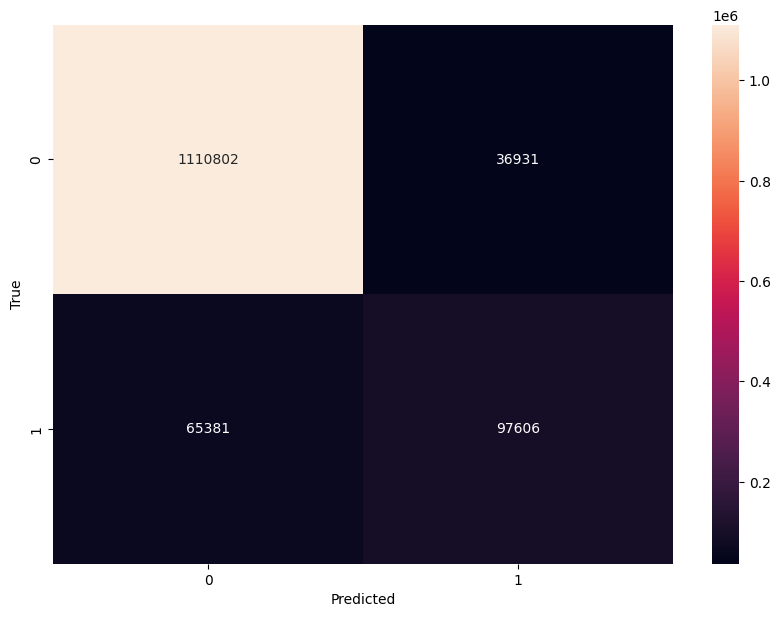

In [ ]:
cm = confusion_matrix(best_epoch_targets, best_epoch_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

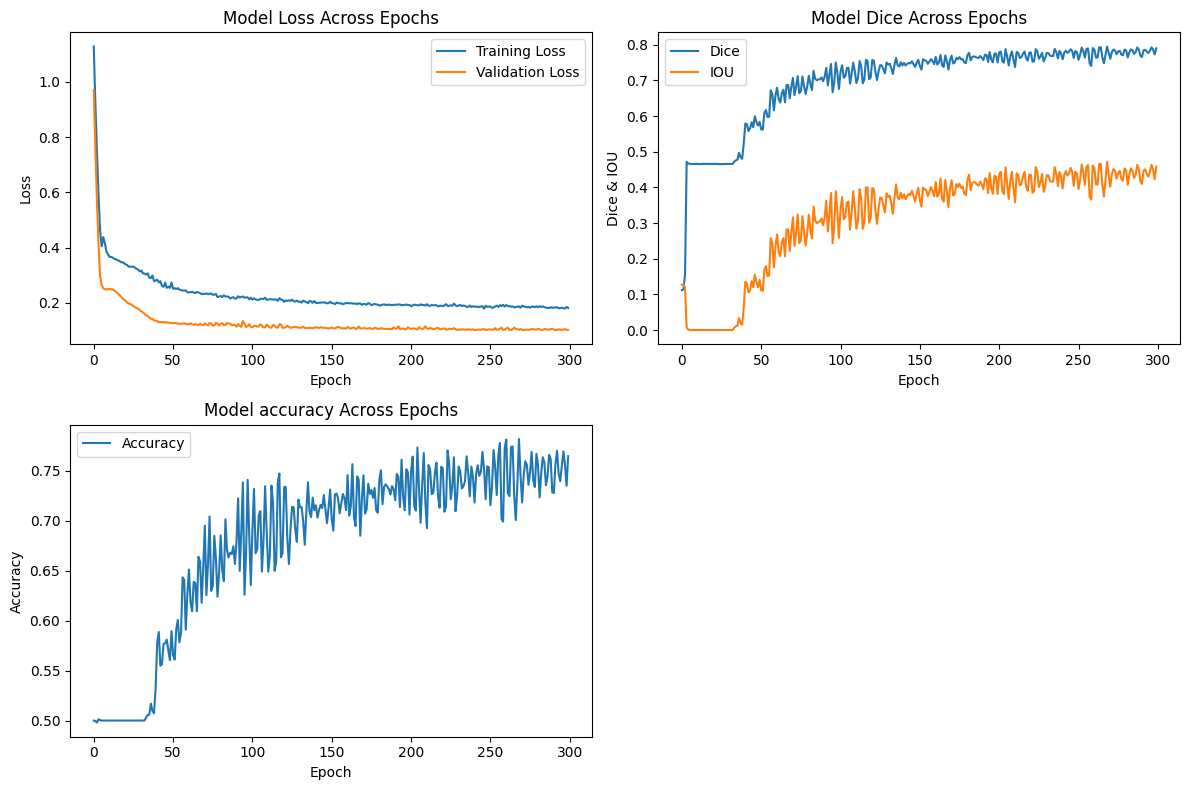

In [ ]:
plt.figure(figsize=(12, 8))

# Plotting Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss Across Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plotting Dice
plt.subplot(2, 2, 2)
plt.plot(dices, label='Dice')
plt.plot(ious, label='IOU')
plt.title('Model Dice Across Epochs')
plt.ylabel('Dice & IOU')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(accs, label='Accuracy')
plt.title('Model accuracy Across Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


plt.tight_layout()
plt.show()

# Test

Index: 0, Unique Predicted Labels: [0 1], Unique True Labels: [0 1]


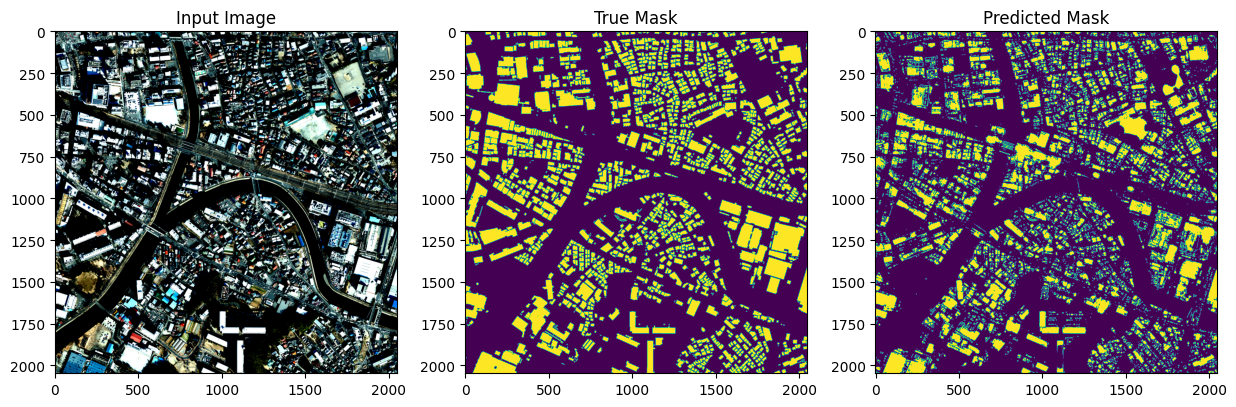

Index: 1, Unique Predicted Labels: [0 1], Unique True Labels: [0 1]


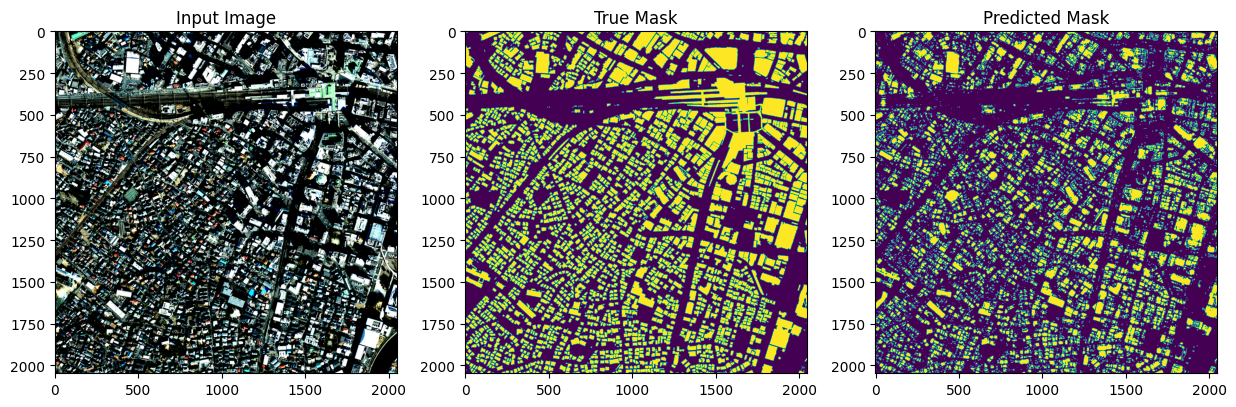

Index: 2, Unique Predicted Labels: [0 1], Unique True Labels: [0 1]


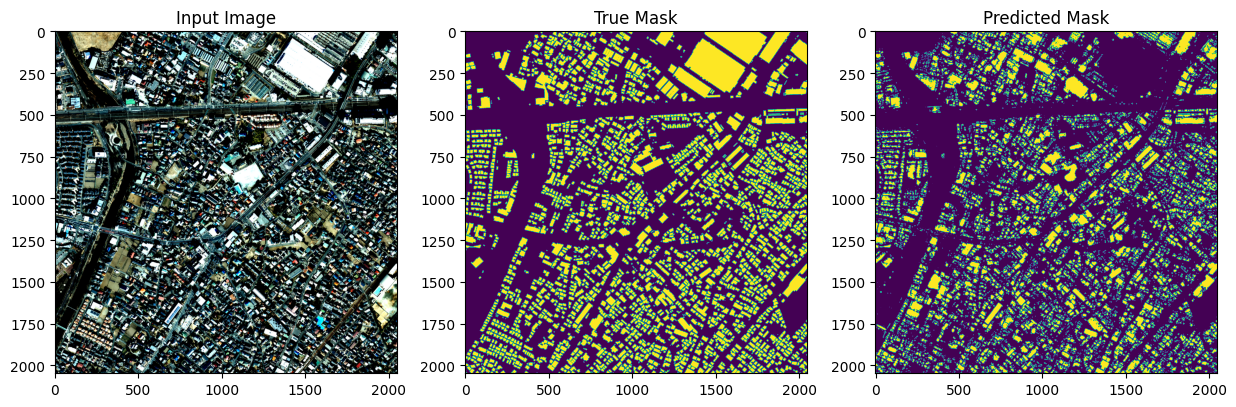

Index: 3, Unique Predicted Labels: [0 1], Unique True Labels: [0 1]


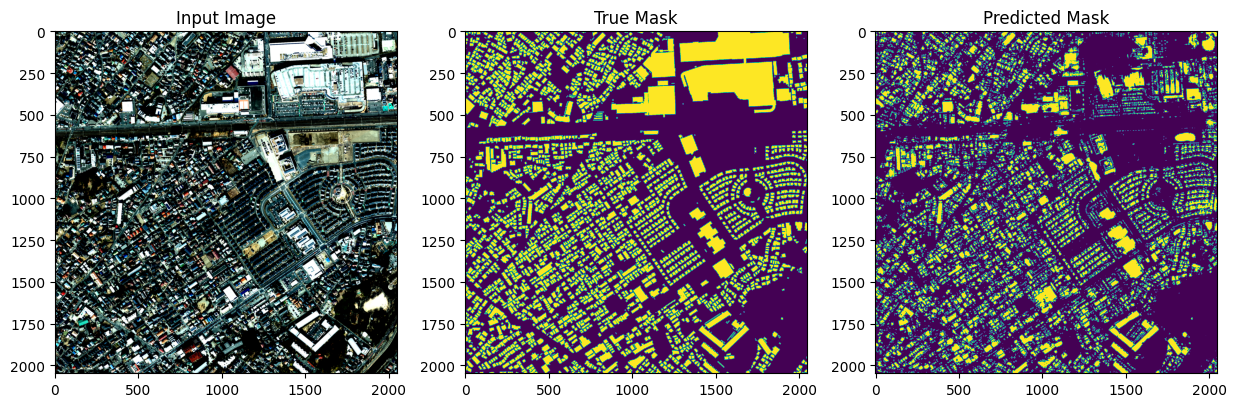

Index: 4, Unique Predicted Labels: [0 1], Unique True Labels: [0 1]


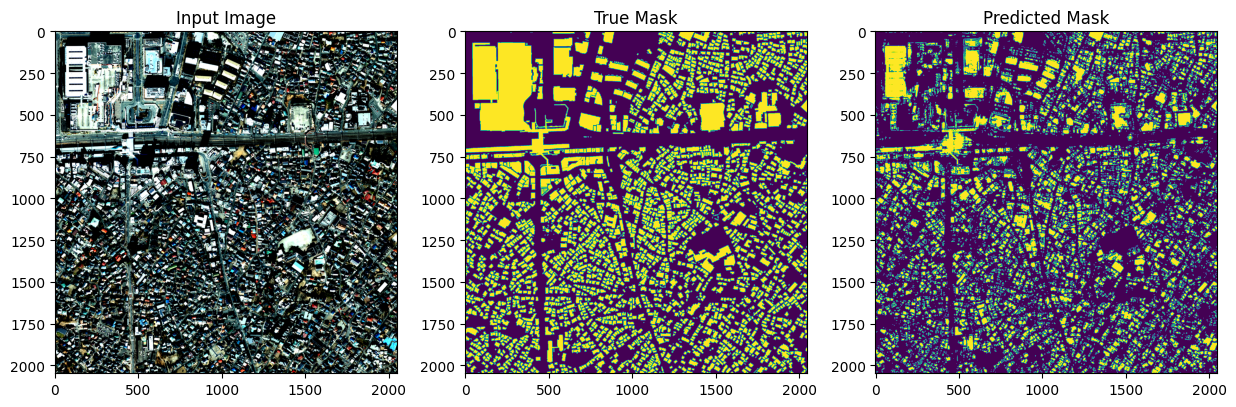

Index: 5, Unique Predicted Labels: [0 1], Unique True Labels: [0 1]


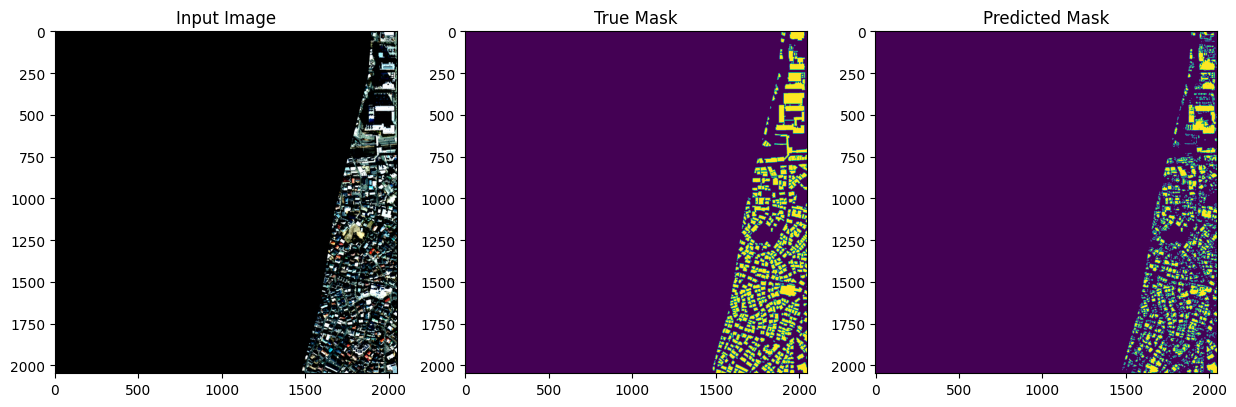

Index: 6, Unique Predicted Labels: [0], Unique True Labels: [0]


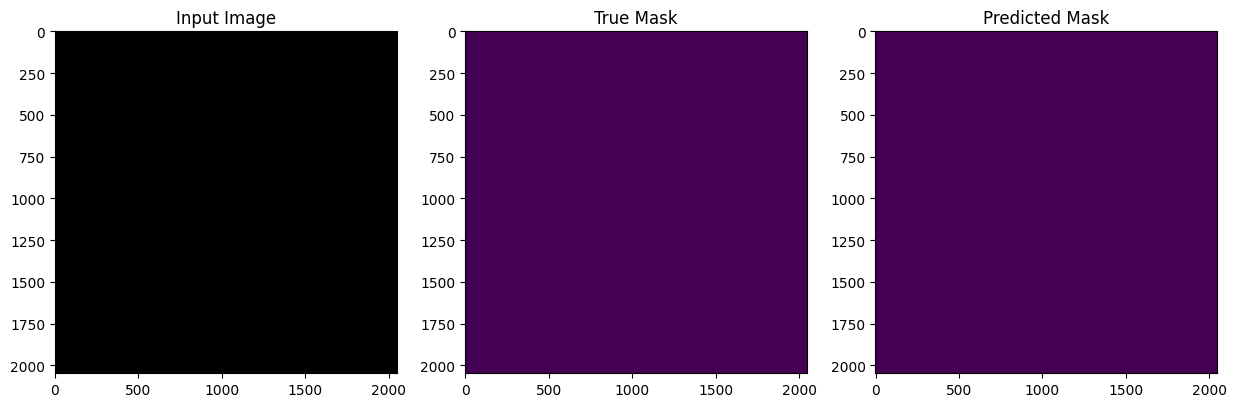

Index: 7, Unique Predicted Labels: [0 1], Unique True Labels: [0 1]


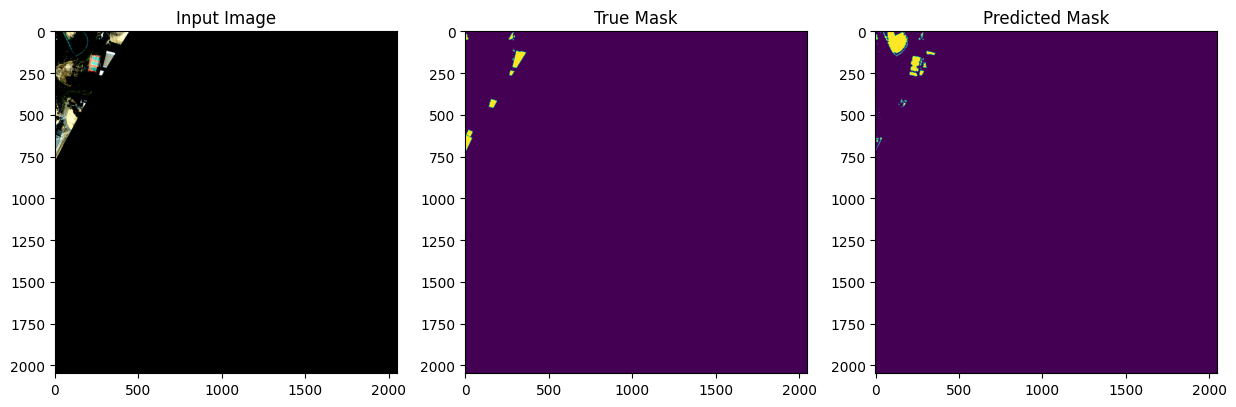

Index: 8, Unique Predicted Labels: [0 1], Unique True Labels: [0 1]


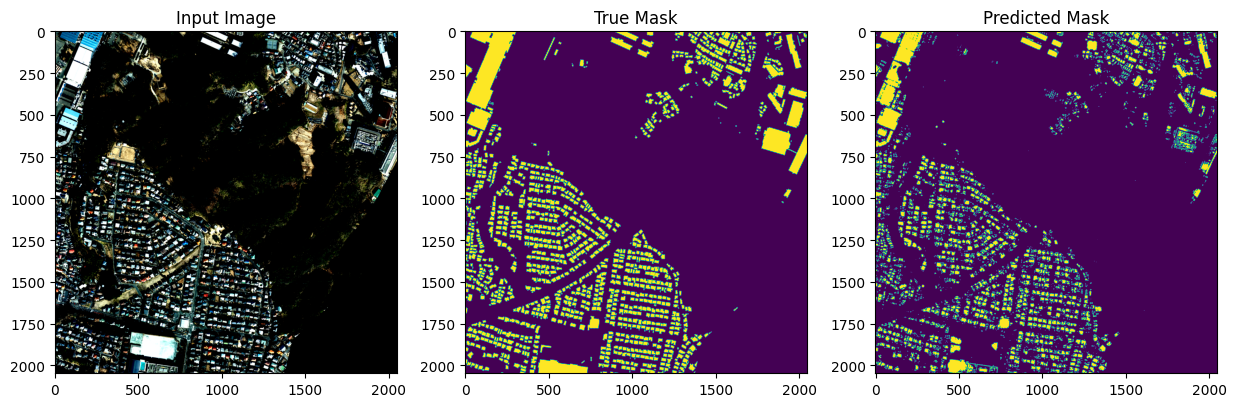

Index: 9, Unique Predicted Labels: [0 1], Unique True Labels: [0 1]


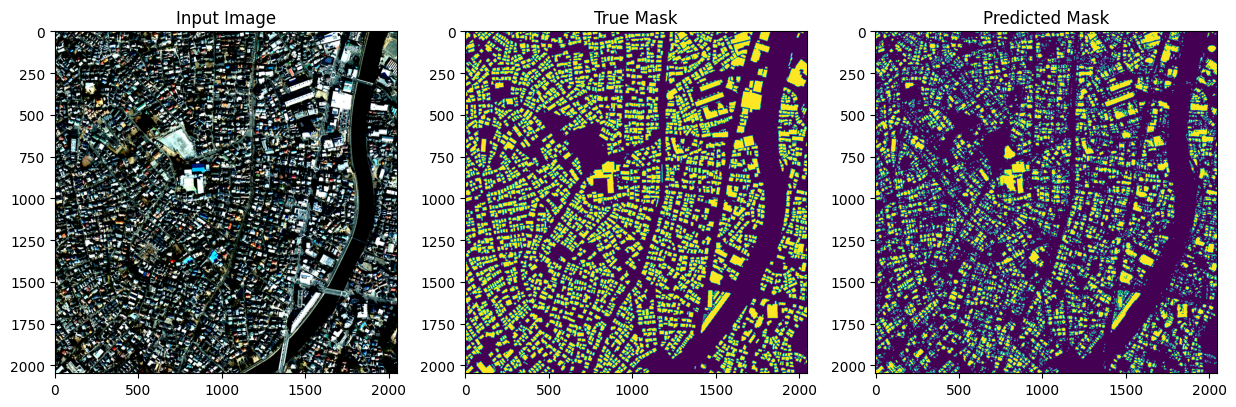

In [ ]:
import matplotlib.pyplot as plt

model.eval()
for idx in range(len(test_dataset)):
    with torch.no_grad():
        x, y = test_dataset[idx]
        x = x.unsqueeze(0).to(device)  # Add batch dimension and move to device
        y_hat = model(x)  # Shape: (batch_size, num_classes, H, W)
        y_hat_mask = y_hat.argmax(dim=1).squeeze().cpu()  # Get the predicted class labels

    print(f"Index: {idx}, Unique Predicted Labels: {np.unique(y_hat_mask)}, Unique True Labels: {np.unique(y)}")
    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots
    axs[0].imshow(x.squeeze().cpu().permute(1, 2, 0))  # Display the input image
    axs[0].set_title('Input Image')
    axs[1].imshow(y)  # Display the ground truth mask
    axs[1].set_title('True Mask')
    axs[2].imshow(y_hat_mask)  # Display the predicted mask
    axs[2].set_title('Predicted Mask')
    plt.show()
